In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


In [8]:
train_dir = r"FER2013\train"
test_dir  = r"FER2013\test"


In [9]:
IMG_SIZE = (48, 48)
BATCH = 64

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    color_mode="grayscale",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    color_mode="grayscale",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=42
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    color_mode="grayscale",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False
)


Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


Số lượng ảnh mỗi lớp: {'angry': 3995, 'disgusted': 436, 'fearful': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprised': 3171}


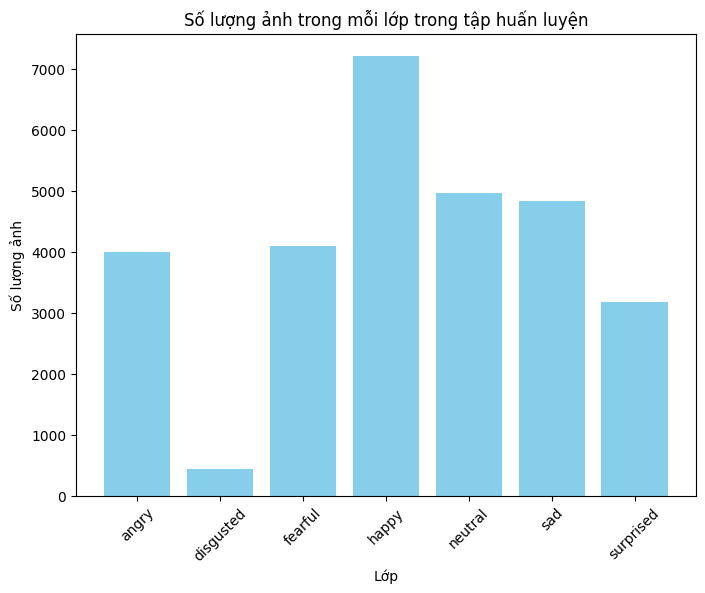

In [10]:
import os
import matplotlib.pyplot as plt

train_dir = r"FER2013\train" 

classes = os.listdir(train_dir)

class_counts = {}
for class_name in classes:
    class_path = os.path.join(train_dir, class_name)   # sửa ở đây
    if os.path.isdir(class_path):
        num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        class_counts[class_name] = num_images

print("Số lượng ảnh mỗi lớp:", class_counts)

# Vẽ biểu đồ cột
plt.figure(figsize=(8,6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Số lượng ảnh trong mỗi lớp trong tập huấn luyện")
plt.xlabel("Lớp")
plt.ylabel("Số lượng ảnh")
plt.xticks(rotation=45)
plt.show()


In [11]:
# Định nghĩa hàm chuẩn hóa (Normalization)
def preprocess(x, y):
    # Chuyển đổi sang float32 và chia cho 255.0 để chuẩn hóa về phạm vi [0.0, 1.0]
    x = tf.cast(x, tf.float32) / 255.0
    return x, y

# Áp dụng chuẩn hóa (.map) và Tối ưu hóa hiệu suất (.prefetch) cho cả 3 dataset
train_ds = train_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

datagen = ImageDataGenerator(
    rescale=1./255,           # chuẩn hóa
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

def build_cnn(input_shape=(48,48,1), n_classes=7):
    inp = layers.Input(input_shape)
    x = layers.Conv2D(32,(3,3),padding='same',activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64,(3,3),padding='same',activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(64,(3,3),padding='same',activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128,(5,5),padding='same',activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(128,(3,3),padding='same',activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256,(5,5),padding='same',activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(256,(3,3),padding='same',activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128,activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128,activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    out = layers.Dense(n_classes, activation='softmax')(x)
    return models.Model(inputs=inp, outputs=out)

model = build_cnn()
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_9 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_8 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_10 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0   

den day roi


In [19]:

def loss_function(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.0)
    loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1)
    return tf.reduce_mean(loss)

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=loss_function,
    metrics=['accuracy']
)


In [20]:


abc = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

history = model.fit(
    train_ds,               
    validation_data=val_ds,
    epochs= 55,              
    verbose=1,
    shuffle=True,
    callbacks = abc
)

Epoch 1/55
359/359 [==============================] - 23s 57ms/step - loss: 1.7587 - accuracy: 0.3644 - val_loss: 1.5953 - val_accuracy: 0.4065 - lr: 1.0000e-04
Epoch 2/55
359/359 [==============================] - 20s 55ms/step - loss: 1.6469 - accuracy: 0.3880 - val_loss: 1.4563 - val_accuracy: 0.4482 - lr: 1.0000e-04
Epoch 3/55
359/359 [==============================] - 20s 55ms/step - loss: 1.5549 - accuracy: 0.4128 - val_loss: 1.3771 - val_accuracy: 0.4715 - lr: 1.0000e-04
Epoch 4/55
359/359 [==============================] - 20s 56ms/step - loss: 1.4876 - accuracy: 0.4321 - val_loss: 1.3435 - val_accuracy: 0.4924 - lr: 1.0000e-04
Epoch 5/55
359/359 [==============================] - 20s 55ms/step - loss: 1.4279 - accuracy: 0.4563 - val_loss: 1.3089 - val_accuracy: 0.5128 - lr: 1.0000e-04
Epoch 6/55
359/359 [==============================] - 20s 55ms/step - loss: 1.3790 - accuracy: 0.4752 - val_loss: 1.2906 - val_accuracy: 0.5177 - lr: 1.0000e-04
Epoch 7/55
359/359 [==============

In [21]:
import numpy as np

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

y_pred = model.predict(test_ds)
y_pred_labels = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_labels, digits=4))


113/113 [==============================] - 2s 14ms/step
              precision    recall  f1-score   support

           0     0.5642    0.4906    0.5248       958
           1     0.9259    0.2252    0.3623       111
           2     0.5017    0.2832    0.3620      1024
           3     0.8184    0.8331    0.8257      1774
           4     0.5514    0.5742    0.5626      1233
           5     0.4233    0.6399    0.5096      1247
           6     0.7778    0.7160    0.7456       831

    accuracy                         0.6080      7178
   macro avg     0.6518    0.5375    0.5561      7178
weighted avg     0.6218    0.6080    0.6028      7178



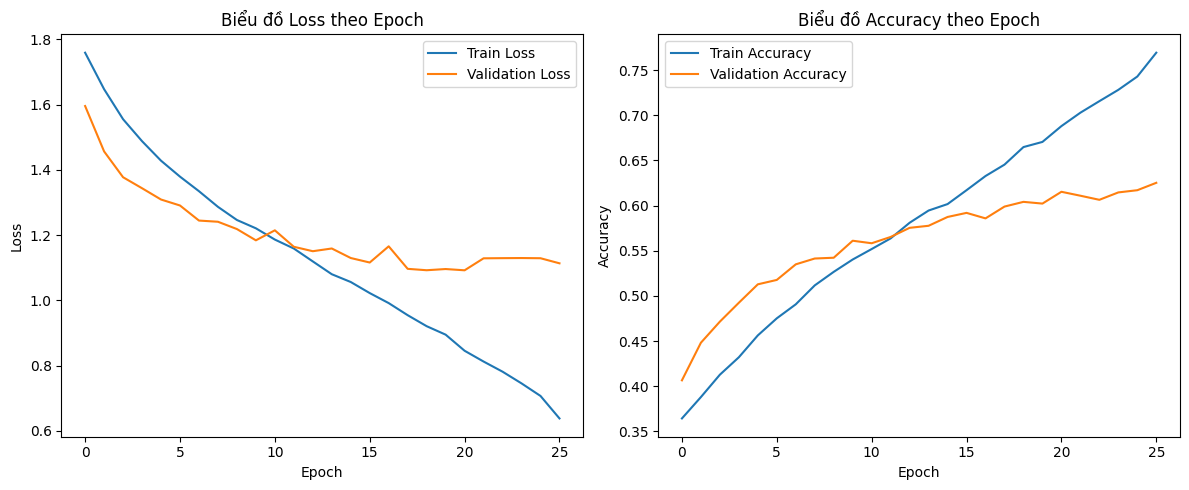

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Biểu đồ Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Biểu đồ Loss theo Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Biểu đồ Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Biểu đồ Accuracy theo Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Ma trận nhầm lẫn của Nhận diện cảm xúc')

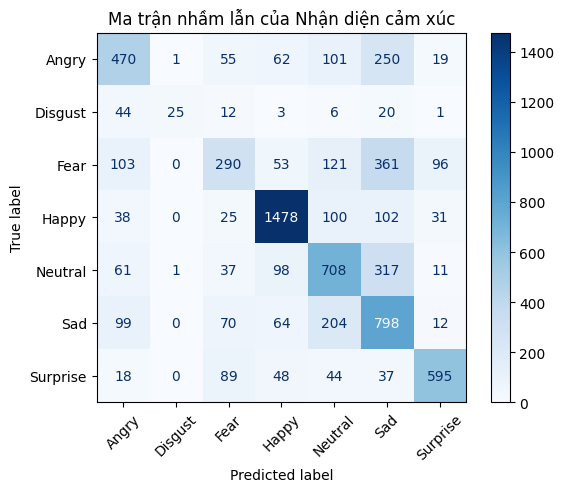

In [23]:
from sklearn import metrics
import matplotlib.pyplot as plt

emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
cm = metrics.confusion_matrix(y_true, y_pred_labels)

disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotion_labels)
disp.plot(cmap='Blues', xticks_rotation=45)

plt.title("Ma trận nhầm lẫn của Nhận diện cảm xúc")


In [24]:
model.save('cnn_model_fer.h5')